In [40]:
import numpy as np
from matplotlib import pyplot as plt

# Simulation parameters
L = 256 # domain
H = 128 # range
seed = np.random.SeedSequence().entropy  # `None` if random desired, integer otherwise
n = int(L*H/3*2) # number of particles to deposit
print(f'Simulation length: {L} units\nSimulation height: {H} units\nSimulation seed: {seed}')

Simulation length: 256 units
Simulation height: 128 units
Simulation seed: 310315278311096898623716846501206859557


# Random deposition
Random deposition is defined by,

$\frac{\partial h}{\partial t} = \eta(\vec{x},t),$

which is equivalent to the EW equation with $v=0$. There is no surface tension and therefore no relaxation, so the film growth is uncorrelated in space and time.

## Simulation
Steps:
1. Setting up the discretized simulation area, the height function, the random number generator, and the interface width.
2. Choose a random $x$-position. 
3. Fill in the first empty box at that $x$-position and increase the height function at that $x$ by one.
4. Calculate the interface width after this sample is added.
5. Repeat 2-4 many times.

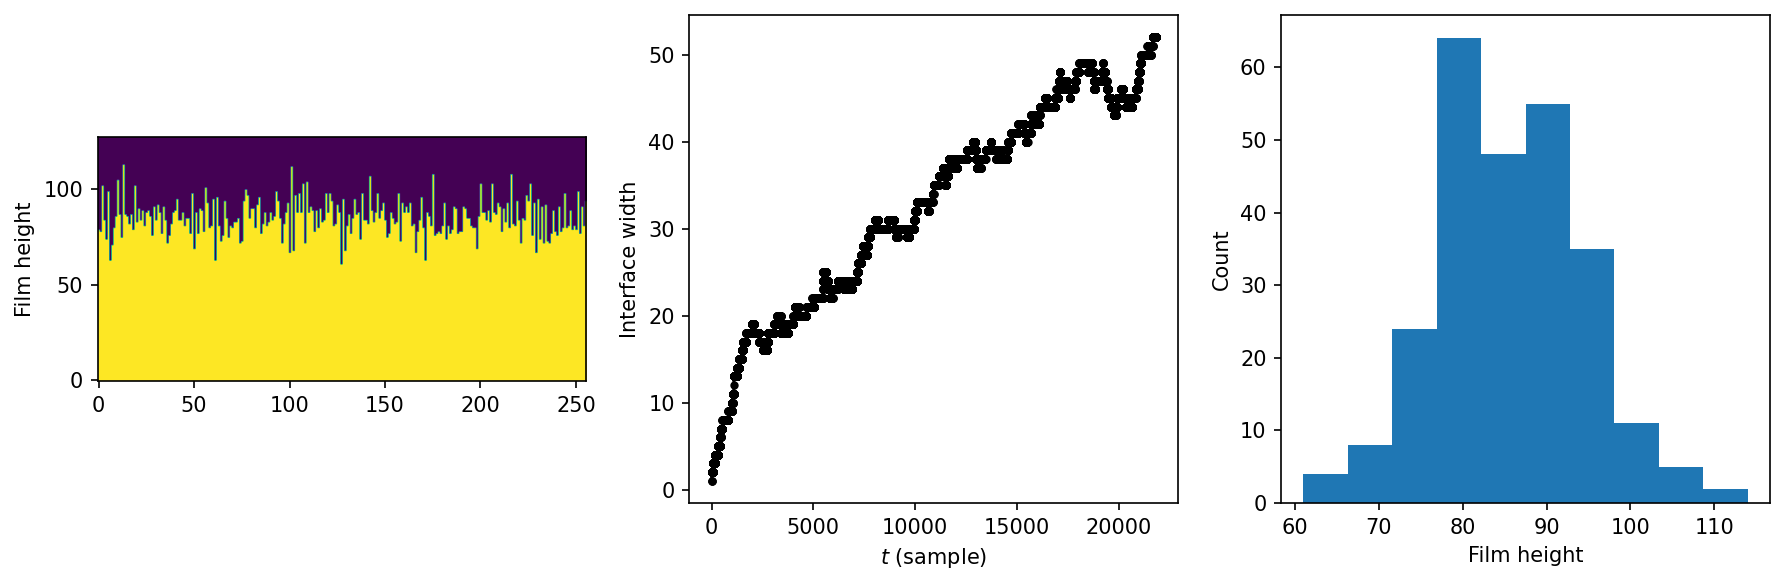

In [41]:
# Set up the simulation area
sim = np.zeros((H, L), dtype=int) # matrix to hold simulation results
height = np.zeros((L,), dtype=int) # track height at each position

# Set up the random number generator
rng = np.random.default_rng(seed=seed)

# track the interface width as a function of time
w = np.zeros(n, dtype=int)

# Now simulate
for i in range(n):
    # Choose a random discrete position on the surface
    x = rng.integers(0, L)

    # The particle adheres there
    sim[height[x],x] = 1
    height[x] += 1
    
    # record current interface width
    w[i] = np.max(height) - np.min(height)

# Visualize
fig, ax = plt.subplots(1,3, figsize=(12,4), dpi=150)
ax[0].imshow(sim, origin='lower')
ax[0].set_ylabel('Film height')
ax[1].plot(w, 'k.', linestyle='-')
ax[1].set_xlabel('$t$ (sample)')
ax[1].set_ylabel('Interface width')
ax[2].hist(height, bins=min(10, height.max() - height.min()+1), range=(height.min(), height.max()+1))
ax[2].set_ylabel('Count')
ax[2].set_xlabel('Film height')
fig.tight_layout()
plt.show()

# Deposition with relaxation
Let's include relaxation, which implies the EW equation,

$\frac{\partial h}{\partial t} = v\nabla^2h + \eta(\vec{x},t).$

We don't need to know $v$; instead we can implement a physical model and let the results speak for themselves. Let's change the code to let incoming particles relax a single step by checking the neighboring columns. If one of the neighbors has a lower height than the current column, move the particle to the neighboring column. If not, don't move the particle.

## Simulation
Steps:
1. Setting up the discretized simulation area, the height function, the random number generator, and the interface width.
2. Choose a random $x$-position. 
3. Check the heights in $x-1$, $x$, and $x+1$. Determine which height is the lowest and call that $x'$. If $x$ is tied for the lowest let $x' = 1$. If $x = 0$ don't check $x-1$; if $x=L-1$ don't check $x+1$.
4. Fill in the first empty box at that $x'$-position and increase the height function at that $x'$ by one.
5. Calculate the interface width after this sample is added.
6. Repeat 2-5 many times.

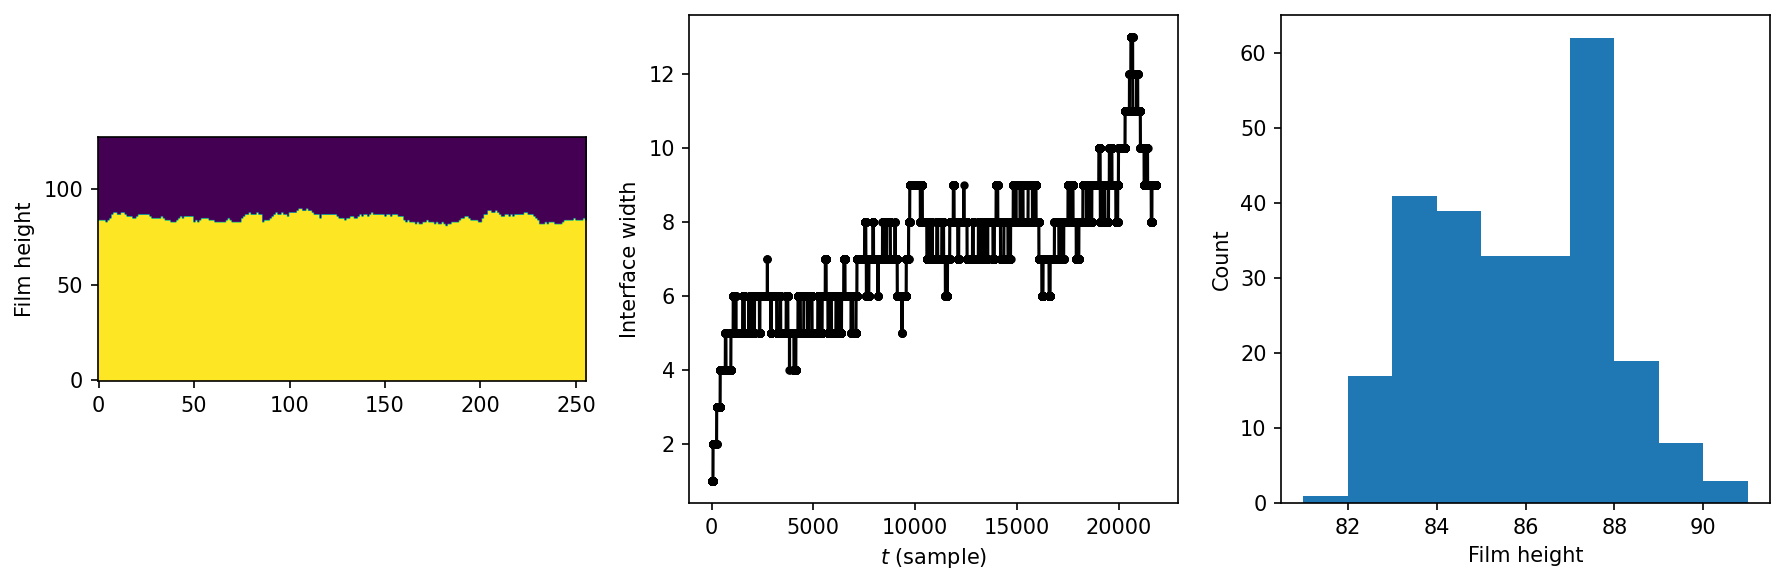

In [42]:
# Set up the simulation area
sim = np.zeros((H, L), dtype=int) # matrix to hold simulation results
height = np.zeros((L,), dtype=int) # track height at each position

# Set up the random number generator
rng = np.random.default_rng(seed)

# track the interface width
w = np.zeros(n, dtype=int)

# Now simulate
for i in range(n):
    # Choose a random discrete position on the surface
    x = rng.integers(0, L)

    # Get the height at that position
    h0 = height[x]

    # Need to respect periodic boundaries to find neighbors
    if x > 0:
        xn1 = x - 1
    else:
        xn1 = x
    
    if x < L - 1:
        xp1 = x + 1
    else:
        xp1 = x
        
    # Get the height at the neighboring positions
    hn1 = height[xn1]
    hp1 = height[xp1]

    # The particle adheres in the lowest of the three possible positions
    if h0 <= hn1 and h0 <= hp1:
        sim[height[x],x] = 1
        height[x] += 1
    elif hn1 < h0 and hn1 <= hp1:
        sim[height[xn1],xn1] = 1
        height[xn1] += 1
    else:
        sim[height[xp1],xp1] = 1
        height[xp1] += 1
        
    # record current interface width
    w[i] = np.max(height) - np.min(height)

# Visualize
fig, ax = plt.subplots(1,3, figsize=(12,4), dpi=150)
ax[0].imshow(sim, origin='lower')
ax[0].set_ylabel('Film height')
ax[1].plot(w, 'k.', linestyle='-')
ax[1].set_xlabel('$t$ (sample)')
ax[1].set_ylabel('Interface width')
ax[2].hist(height, bins=min(10, height.max() - height.min()+1), range=(height.min(), height.max()+1))
ax[2].set_ylabel('Count')
ax[2].set_xlabel('Film height')
fig.tight_layout()
plt.show()

# Periodic boundary conditions
Depending on your random number generator, you may see that the first and last columns don't reflect the more interior positions well. This can be due to boundary effects, some of which can be mitigated by periodic boundary conditions (PBCs). While a number of potential conditions exist, usually the condition $x+L \to x$ is used. The growth direction does not have PBCs imposed (the source is very far away compared to the area of interest), so 2D simulations are sometimes called (1+1)D simulations to reflect that only one direction has a PBC. Similarly, 3D simulations are sometimes called (2+1)D simulations.

Change the code to reflect periodic boundary conditions during the relaxation step.

## Simulation
Steps:
1. Setting up the discretized simulation area, the height function, the random number generator, and the interface width.
2. Choose a random $x$-position. 
3. Check the heights in $x-1$, $x$, and $x+1$. Determine which height is the lowest and call that $x'$. If $x$ is tied for the lowest let $x' = 1$. If $x = 0$ don't check $x-1$; instead, check $x=L-1$. If $x=L-1$ don't check $x+1$; check $x=0$ instead.
4. Fill in the first empty box at that $x'$-position and increase the height function at that $x'$ by one.
5. Calculate the interface width after this sample is added.
6. Repeat 2-5 many times.

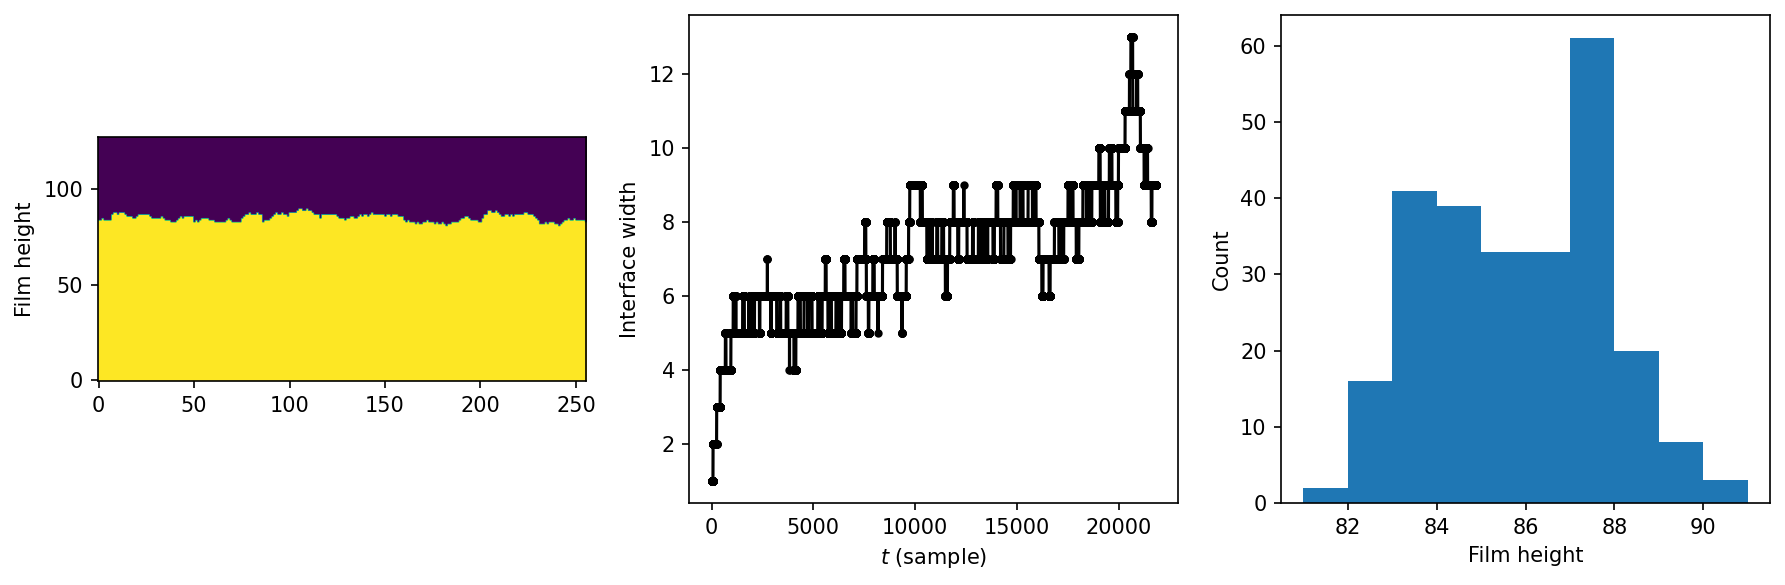

In [43]:
# Set up the simulation area
sim = np.zeros((H, L), dtype=int) # matrix to hold simulation results
height = np.zeros((L,), dtype=int) # track height at each position

# Set up the random number generator
rng = np.random.default_rng(seed)

# track the interface width
w = np.zeros(n, dtype=int)

# Now simulate
for i in range(n):
    # Choose a random discrete position on the surface
    x = rng.integers(0, L)

    # Get the height at that position
    h0 = height[x]

    # Need to respect periodic boundaries to find neighbors
    if x > 0:
        xn1 = x - 1
    else:
        xn1 = L - 1
    
    if x < L - 1:
        xp1 = x + 1
    else:
        xp1 = 0
        
    # Get the height at the neighboring positions
    hn1 = height[xn1]
    hp1 = height[xp1]

    # The particle adheres in the lowest of the three possible positions
    if h0 <= hn1 and h0 <= hp1:
        sim[height[x],x] = 1
        height[x] += 1
    elif hn1 < h0 and hn1 <= hp1:
        sim[height[xn1],xn1] = 1
        height[xn1] += 1
    else:
        sim[height[xp1],xp1] = 1
        height[xp1] += 1
        
    # record current interface width
    w[i] = np.max(height) - np.min(height)

# Visualize
fig, ax = plt.subplots(1,3, figsize=(12,4), dpi=150)
ax[0].imshow(sim, origin='lower')
ax[0].set_ylabel('Film height')
ax[1].plot(w, 'k.', linestyle='-')
ax[1].set_xlabel('$t$ (sample)')
ax[1].set_ylabel('Interface width')
ax[2].hist(height, bins=min(10, height.max() - height.min()+1), range=(height.min(), height.max()+1))
ax[2].set_ylabel('Count')
ax[2].set_xlabel('Film height')
fig.tight_layout()
plt.show()

# Longer relaxation time
Many particles will diffuse further than just one step. Change the code so that the relaxing particle can move up to a given number of times, <code>relaxation_steps</code>. If $x$ is the lowest position at any point then it will stick permanently at $x$.

## Simulation
Steps:
1. Setting up the discretized simulation area, the height function, the random number generator, and the interface width.
2. Choose a random $x$-position. 
3. Check the heights in $x-1$, $x$, and $x+1$. Determine which height is the lowest and call that $x'$. If $x$ is tied for the lowest let $x' = 1$. If $x = 0$ don't check $x-1$; instead, check $x=L-1$. If $x=L-1$ don't check $x+1$; check $x=0$ instead.
4. Repeat 3 <code>relaxation_steps</code> times or until $x' = x$.
5. Fill in the first empty box at that $x'$-position and increase the height function at that $x'$ by one.
6. Calculate the interface width after this sample is added.
7. Repeat 2-6 many times.

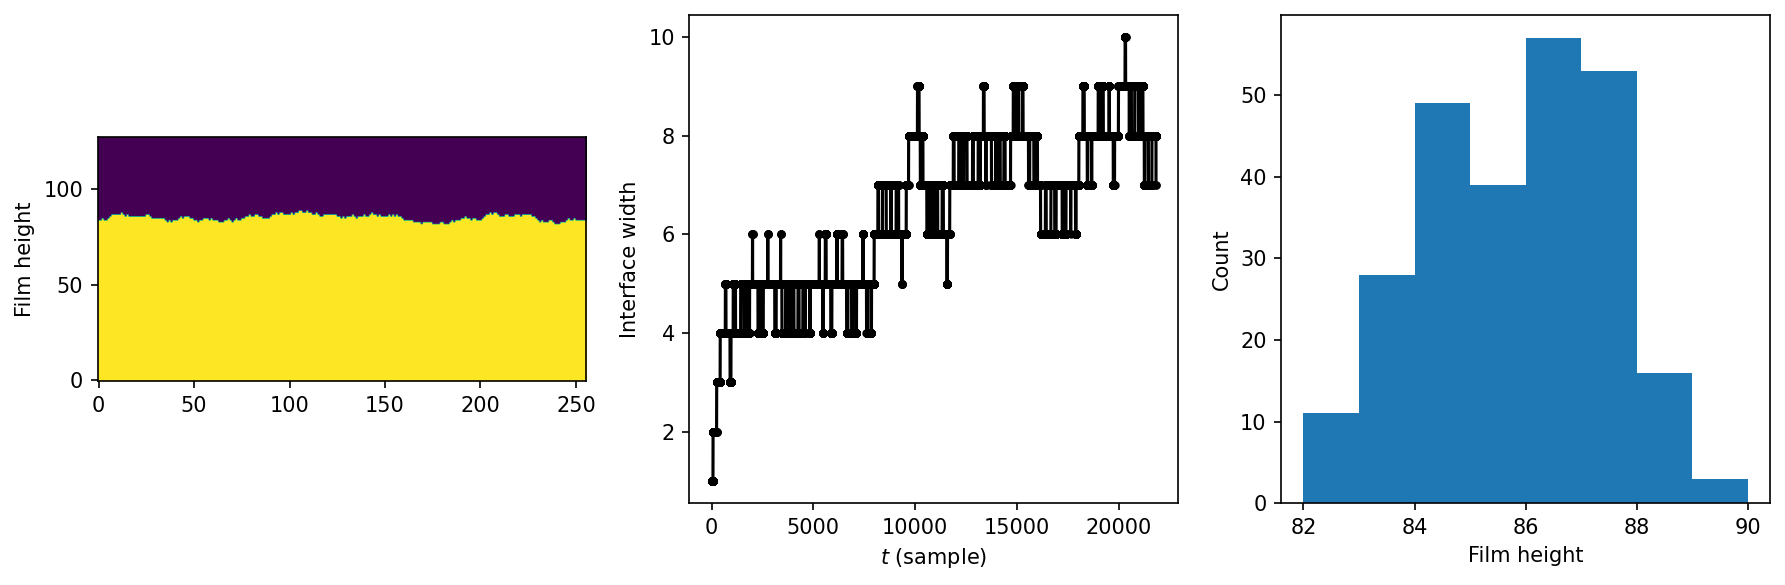

In [44]:
relaxation_steps = 50 # set your relaxation steps here

# Set up the simulation area
sim = np.zeros((H, L), dtype=int) # matrix to hold simulation results
height = np.zeros((L,), dtype=int) # track height at each position

# track the interface width
w = np.zeros(n, dtype=int)

# Set up the random number generator
rng = np.random.default_rng(seed)

# Now simulate
for i in range(n):
    # Choose a random discrete position on the surface
    x = rng.integers(0, L)

    # Relax a set number of times
    for r in range(relaxation_steps):
        # Get the height at the current position
        h0 = height[x]
        
        # Need to respect periodic boundaries to find neighbors
        if x > 0:
            xn1 = x - 1
        else:
            xn1 = L - 1
        
        if x < L - 1:
            xp1 = x + 1
        else:
            xp1 = 0
            
        # Get the height at the neighboring positions
        hn1 = height[xn1]
        hp1 = height[xp1]

        # Change current position to the lowest of the three
        if relaxation_steps - r > 1:
            if h0 <= hn1 and h0 <= hp1:
                break # if the particle won't move now then it never will
            elif hn1 < h0 and hn1 <= hp1:
                x = xn1
            else:
                x = xp1
    
    # The particle adheres in the lowest of the three possible positions
    if h0 <= hn1 and h0 <= hp1:
        sim[height[x],x] = 1
        height[x] += 1
    elif hn1 < h0 and hn1 <= hp1:
        sim[height[xn1],xn1] = 1
        height[xn1] += 1
    else:
        sim[height[xp1],xp1] = 1
        height[xp1] += 1

    # record current interface width
    w[i] = np.max(height) - np.min(height)

# Visualize
fig, ax = plt.subplots(1,3, figsize=(12,4), dpi=150)
ax[0].imshow(sim, origin='lower')
ax[0].set_ylabel('Film height')
ax[1].plot(w, 'k.', linestyle='-')
ax[1].set_xlabel('$t$ (sample)')
ax[1].set_ylabel('Interface width')
ax[2].hist(height, bins=min(10, height.max() - height.min()+1), range=(height.min(), height.max()+1))
ax[2].set_ylabel('Count')
ax[2].set_xlabel('Film height')
fig.tight_layout()
plt.show()